In [1]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1432, 52)


#### Construction des jeux d'entrainement et de test

In [3]:
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(min("week_start_date"), max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(min("week_start_date"), max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (920, 52)
	date_start = 1990-08-20 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (512, 52)
	date_start = 2000-08-26 / date_stop = 2010-06-25


In [4]:
import datetime

delta = datetime.timedelta(weeks=52)

cut_date_iq = max_date_iq - delta
cut_date_sj = max_date_sj - delta

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (868, 52)
test_sj = (52, 52)
train_iq = (460, 52)
test_iq = (52, 52)


In [5]:
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1328, 52)
test = (104, 52)


### Plot

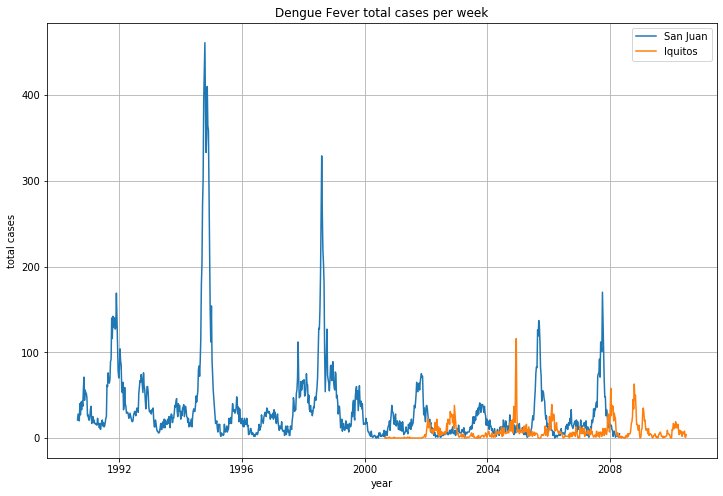

In [6]:
pd_train_sj = df_train_sj.toPandas()
pd_train_iq = df_train_iq.toPandas()

# Total cases per city
plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

plt.show()

### Construction du *pipeline*

In [7]:
indexer = StringIndexer(inputCol='city', outputCol='city_')

encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

vectorAssembler = VectorAssembler(
    inputCols=['year', 'weekofyear',
               #'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'reanalysis_air_temp_c','reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c',
               'reanalysis_min_air_temp_c', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
              # 'reanalysis_specific_humidity_g_per_kg', 
               #'reanalysis_tdtr_c',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',
               'cityVect'], 
    outputCol = 'features')

scaler = StandardScaler(inputCol='features',
                        outputCol="scaled_features",
                        withStd=True, withMean=True)

lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

In [8]:
vectorAssembler2 = VectorAssembler(
    inputCols=['year', 'weekofyear',
               #'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'reanalysis_air_temp_c','reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c',
               'reanalysis_min_air_temp_c', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               #'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c',
               'station_min_temp_c', 
               'station_precip_mm',
               'station_avg_temp_1_c', 'station_avg_temp_2_c', 'station_avg_temp_3_c', 'station_avg_temp_4_c',
             'd_station_avg_temp_1_c', 'd_station_avg_temp_2_c', 'd_station_avg_temp_3_c', 'd_station_avg_temp_4_c',
            'station_precip_1_mm', 'station_precip_2_mm', 'station_precip_3_mm', 'station_precip_4_mm',
             'd_station_precip_1_mm', 'd_station_precip_2_mm', 'd_station_precip_3_mm', 'd_station_precip_4_mm',
            'reanalysis_sat_precip_amt_1_mm', 'reanalysis_sat_precip_amt_2_mm',
            'reanalysis_sat_precip_amt_3_mm', 'reanalysis_sat_precip_amt_4_mm',
            'd_reanalysis_sat_precip_amt_1_mm', 'd_reanalysis_sat_precip_amt_2_mm',
            'd_reanalysis_sat_precip_amt_3_mm', 'd_reanalysis_sat_precip_amt_4_mm',
               'cityVect'], 
    outputCol = 'features')

### 1. Linear regression

#### 1.1 Simple

In [ ]:
pipeline_lr = Pipeline(stages=[indexer, encoder, vectorAssembler2, scaler, lr])

evaluator_lr = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='lr_prediction',
                                   metricName="mae")

model_lr = pipeline_lr.fit(train)

# Build prediction from 'test' dataset
pred_lr = model_lr.transform(test)

pred_lr.select(['total_cases','lr_prediction']).show(10)

mae = evaluator_lr.evaluate(pred_lr)

print("Linear regression::Before grid search - MAE = {:.3f}".format(mae))

#### 1.2 Cross validation

In [ ]:
# Parameter grid for linear regression (LR)
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator_lr,
                             numFolds=2,
                             seed=18)

cv_model_lr = crossval_lr.fit(train)

# Build prediction from 'test' dataset
cv_pred_lr = cv_model_lr.transform(test)

mae = evaluator_lr.evaluate(cv_pred_lr)

print("Linear regression::After grid search - MAE = {:.3f}".format(mae))

### 2. Random Forest

#### 2.1 Simple

In [9]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler2, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

+-----------+------------------+
|total_cases|     rf_prediction|
+-----------+------------------+
|         10|11.812770638624675|
|          8|11.758842922111565|
|         13|19.810009468399123|
|         10|14.313726225767912|
|         21|12.333141094675797|
|         18|19.418151451503093|
|         21|  20.7342389202281|
|         34| 25.81919600877548|
|         25|25.163584684224794|
|         34|38.525444647191435|
|         33|25.313598537576222|
|         40| 25.04650279552526|
|         42| 19.42693519114394|
|         36| 32.94999175346691|
|         72| 32.20100685522898|
|         75| 32.61774122205263|
|         76|23.359999003417922|
|         92|24.154362768934277|
|         71| 23.76690413372848|
|        112| 25.78116897602904|
|        106|27.011450880514037|
|        101|26.707026511350858|
|        170| 34.55430635241784|
|        135| 32.45356937966541|
|        106|31.712040230552333|
|         68| 37.52055905856295|
|         48|28.193659612136788|
|         

#### 2.2 Cross-Validation

In [10]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=2,
                             seed=18)

cv_model_rf = crossval_rf.fit(train)

# Build prediction from 'test' dataset
cv_pred_rf = cv_model_rf.transform(test)

mae = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search - MAE = {:.3f}".format(mae))

Random Forest::After grid search - MAE = 13.273


In [11]:
cv_model_rf.bestModel.stages[-1].getNumTrees

50

#### plot

In [12]:
# create pandas dataframe from spark dataframe
pd_pred_rf = cv_pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

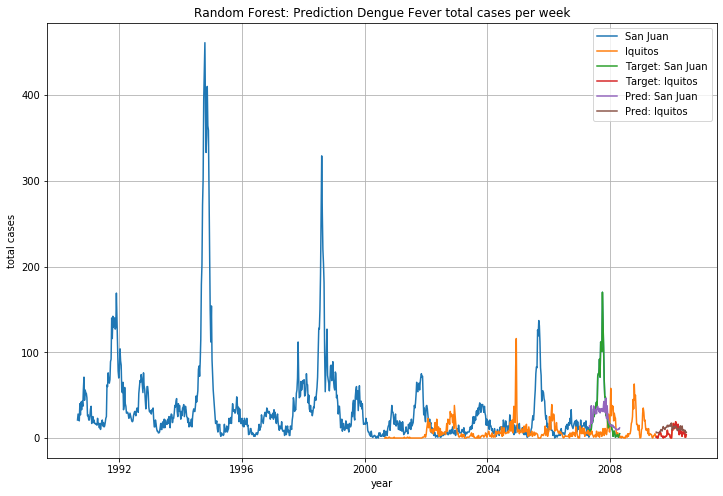

In [13]:
# Total cases per city
plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Target: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Target: Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['rf_prediction'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['rf_prediction'], label='Pred: Iquitos')

plt.legend()

plt.show()

## plot LR

In [ ]:
# create pandas dataframe from spark dataframe
pd_pred_lr = cv_pred_lr.toPandas()

pd_pred_lr_sj = pd_pred_lr[pd_pred_lr['city'] == 'sj']
pd_pred_lr_iq = pd_pred_lr[pd_pred_lr['city'] == 'iq']

In [ ]:
# Total cases per city
plt.figure(figsize=(12, 8))
plt.grid()
plt.title('LR : Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_lr_sj['week_start_date'], pd_pred_lr_sj['total_cases'], label='Target: San Juan')
plt.plot(pd_pred_lr_iq['week_start_date'], pd_pred_lr_iq['total_cases'], label='Target: Iquitos')

plt.plot(pd_pred_lr_sj['week_start_date'], pd_pred_lr_sj['lr_prediction'], label='Pred: San Juan')
plt.plot(pd_pred_lr_iq['week_start_date'], pd_pred_lr_iq['lr_prediction'], label='Pred: Iquitos')

plt.legend()

plt.show()

### try on test bench

In [ ]:
df_bench = spark.read.parquet("data/preprocessed_bench")

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

In [ ]:
# simple RF
bench_simple_rf = cv_model_rf.transform(df_bench)

In [ ]:
df_submission = spark.read.csv('data/submission_format.csv',header=True)
df_submission.show(10)

In [ ]:
df_temp = bench_simple_rf['city', 'year', 'weekofyear','rf_prediction']
df_temp = df_temp.withColumn("total_cases", df_temp["rf_prediction"].cast('int'))
df_temp = df_temp.drop('rf_prediction')

In [ ]:
df_temp.show(10)

In [ ]:
df_temp_pandas = df_temp.select('city','year','weekofyear','total_cases').toPandas()
df_temp_pandas_sj = df_temp_pandas[df_temp_pandas['city'] == 'sj']
df_temp_pandas_iq = df_temp_pandas[df_temp_pandas['city'] == 'iq']
df_temp_pandas = pd.concat([df_temp_pandas_sj,df_temp_pandas_iq], axis=0)

In [ ]:
df_temp_pandas.to_csv('data/test_cv_rf.csv',index=False)